In [137]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [138]:
dir_path = '../../results/DiffExpr/pseudobulks'

In [139]:
os.listdir(dir_path)

['annotation_chimp.csv',
 'annotation_human.csv',
 'annotation_macaque.csv',
 'annotation_spatial_libd_human.csv',
 'expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_mean_chimp.csv',
 'expression_mean_human.csv',
 'expression_mean_macaque.csv',
 'expression_mean_spatial_libd_human.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_sum_human.csv',
 'expression_sum_macaque.csv',
 'expression_sum_spatial_libd_human.csv']

In [140]:
annatation_human_young = pd.read_csv(dir_path + '/annotation_human.csv', index_col=0)
expression_human_young = pd.read_csv(dir_path + '/expression_mean_human.csv', index_col=0)
adata_human_young = an.AnnData(expression_human_young.T, obs=annatation_human_young)
adata_human_young

AnnData object with n_obs × n_vars = 35 × 19966
    obs: 'layer', 'sample_id', 'condition'

In [141]:
annatation_human_old = pd.read_csv(dir_path + '/annotation_spatial_libd_human.csv', index_col=0)
expression_human_old = pd.read_csv(dir_path + '/expression_mean_spatial_libd_human.csv', index_col=0)
adata_human_old = an.AnnData(expression_human_old.T, obs=annatation_human_old)
adata_human_old

AnnData object with n_obs × n_vars = 76 × 33538
    obs: 'layer', 'sample_id', 'condition'

In [159]:
adata = an.concat([adata_human_young, adata_human_old], merge='same')
adata

AnnData object with n_obs × n_vars = 111 × 19404
    obs: 'layer', 'sample_id', 'condition'

## Differential expression

In [172]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Feature selection

In [173]:
sc.pp.highly_variable_genes(
    adata=adata, flavor="seurat", 
    n_top_genes=4000, inplace=True,
    batch_key="condition")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


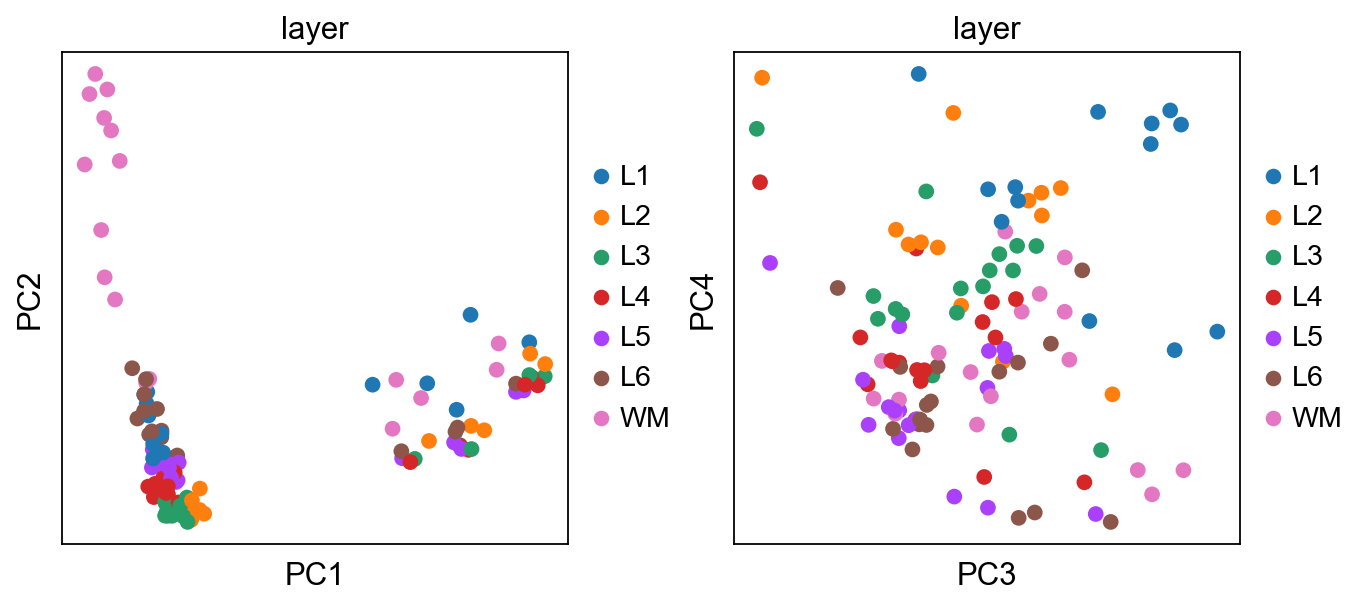

In [174]:
sc.pl.pca(adata, color=['layer'], size=200, ncols=2, components=['1,2', '3, 4'])

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


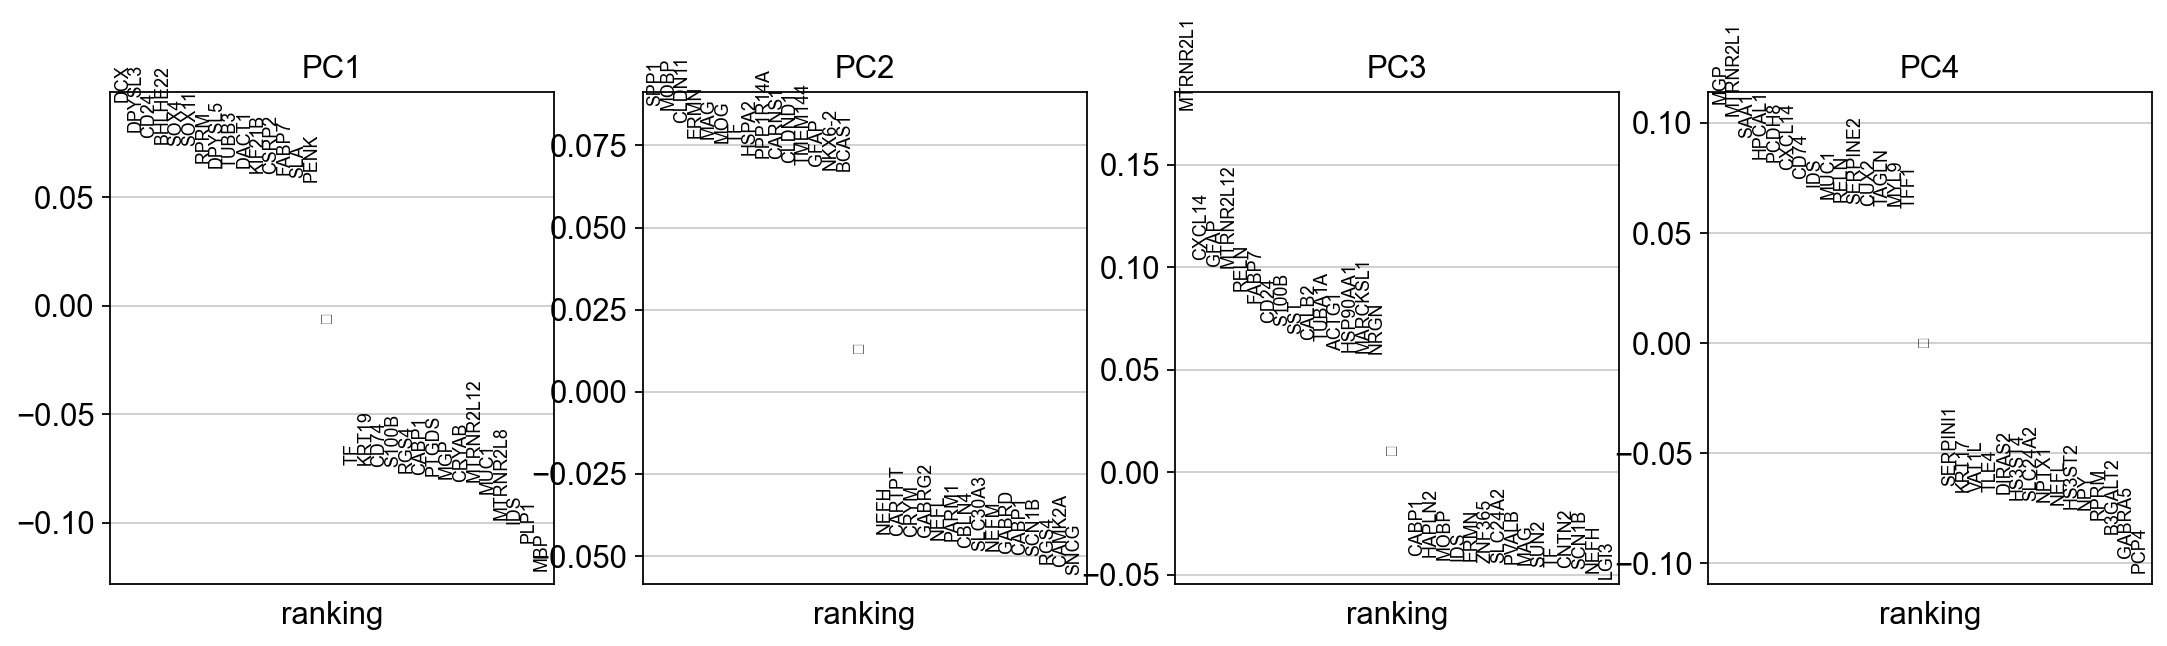

In [175]:
sc.pl.pca_loadings(adata, components=[1,2,3,4])

In [176]:
mito = adata.var_names.str.startswith('MT-')
hb = adata.var_names.str.contains(("^HB[AB]"))
rb = adata.var_names.str.contains(("^RP[LS]"))
remove = mito | hb | rb
genes_to_remove = adata.var_names[remove].tolist()

keep = np.invert(remove)
print(sum(remove))

adata = adata[:,keep]

0


In [177]:
# remove genes from `highly_variable_genes`
highly_variable_genes = adata.var[adata.var.highly_variable].index.tolist()
len(highly_variable_genes)

4000

### Subset

In [178]:
layer = "L1"

In [179]:
de_adata = adata[adata.obs.layer == layer]
de_adata

View of AnnData object with n_obs × n_vars = 13 × 19287
    obs: 'layer', 'sample_id', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'pca', 'hvg', 'layer_colors'
    obsm: 'X_pca'
    varm: 'PCs'

### Rank genes

In [180]:
sc.tl.rank_genes_groups(de_adata, groupby='condition', method='t-test', pts=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


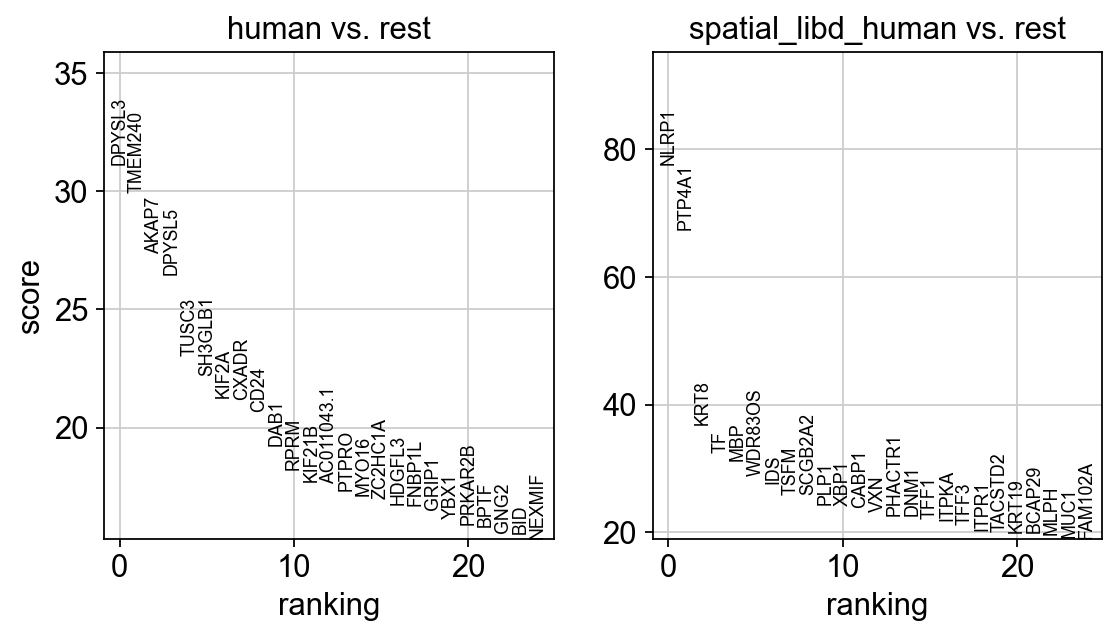

In [181]:
sc.pl.rank_genes_groups(de_adata, n_genes=25, sharey=False)

In [182]:
genes_rank_df = sc.get.rank_genes_groups_df(de_adata, group='human')
genes_rank_df.index = df.names
genes_rank_df

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
names,,,,,,,
AKAP7,DPYSL3,31.133905,2.886935,3.300204e-07,6.982181e-05,1.0,1.0
TMEM240,TMEM240,29.929514,2.963742,1.712561e-11,1.651508e-07,1.0,1.0
SH3GLB1,AKAP7,27.370047,2.609401,1.606606e-10,6.197321e-07,1.0,1.0
DAB1,DPYSL5,26.461338,3.151725,7.048151e-08,2.473903e-05,1.0,1.0
EIF4G2,TUSC3,23.059464,1.498907,2.057964e-10,6.615325e-07,1.0,1.0
...,...,...,...,...,...,...,...
WDR83OS,MBP,-31.116215,-4.363905,1.421400e-09,1.958182e-06,1.0,1.0
TF,TF,-32.369144,-3.497584,6.635028e-11,3.199244e-07,1.0,1.0
IDS,KRT8,-36.882050,-10.026704,2.276067e-09,2.310448e-06,0.2,1.0


<AxesSubplot: >

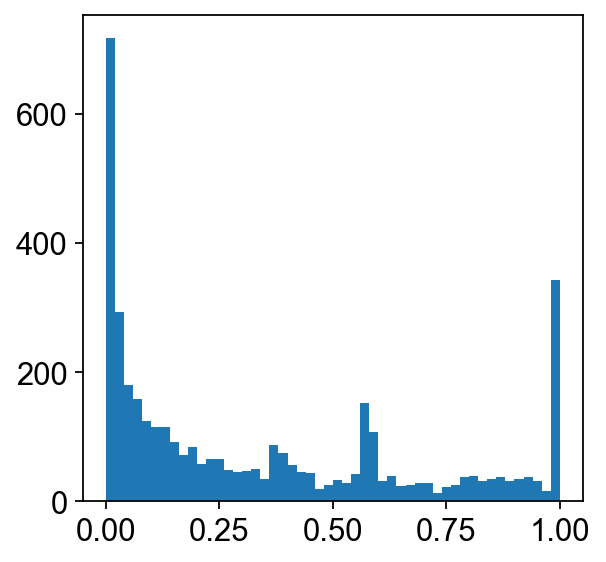

In [183]:
genes_rank_df.loc[highly_variable_genes, 'pvals_adj'].hist(bins=50, grid=False)

Кажется из этого ничего дельного не выйдет